In [3]:
import sys
import os

# Data Manipulation
import pandas as pd
import seaborn as sns
#import plotly.express as px
import pyreadr
from datetime import datetime





# Micro to Macro - Empirical Model

In [9]:
df_amt_raw = df_amt_raw.rename(columns = {'to': 'from_pn','from': 'to_pn'})

In [10]:
!pwd

/Users/jlumma/Documents/pluto_data


In [11]:
subfolder = 'fill_in_'
filename = 'datafile.csv'
file_path = os.path.join(subfolder, filename)


dtype_mapping = {'from_pn': str, 'to_pn': str}

SIC5_clean_test_load = pd.read_csv(file_path,dtype=dtype_mapping)


# Aggregate Volatility from Data

In [17]:
#### This function assumes a dataframe with two columns 'from_pn' and 'to_pn' corresponding to a production formalims framework,
#### where 'from_pn' refers to the supplier of goods and 'to_pn' to the buyer of goods.
#### It computes industry-level output or input depending on the direction variable. It also converts columns to datetime format
#### Moreover it also filters out rows in the dataframes that are not common to output and input 
##### (because certain industries might contain zero costs but not output in the dataset).

def compute_industry_levels(df, direction):
 
    if direction not in ['from_pn', 'to_pn']:
        raise ValueError("The direction parameter must be either 'from_pn' or 'to_pn'.")

    # Perform operations based on 'from_pn'    
    aggregate_output_SIC5 = df.drop(columns = 'to_pn').groupby(['from_pn']).sum()
    aggregate_output_SIC5 = aggregate_output_SIC5[(aggregate_output_SIC5 != 0).all(axis=1)]
     
        

    aggregate_input_SIC5 = df.drop(columns = 'from_pn').groupby(['to_pn']).sum()
    aggregate_input_SIC5 = aggregate_input_SIC5[(aggregate_input_SIC5 != 0).all(axis=1)]
    
    
    
    
    all_columns_contain_amt = all('_amt_' in col for col in df.drop(columns = ['from_pn','to_pn']).columns)
    
    if all_columns_contain_amt:
    #### Switching columns to datetime format
        aggregate_output_SIC5.columns = aggregate_output_SIC5.columns.str.replace('_amt_', '_')
        aggregate_output_SIC5.columns = pd.to_datetime(aggregate_output_SIC5.columns, format='%b_%y')

    
        aggregate_input_SIC5.columns = aggregate_input_SIC5.columns.str.replace('_amt_', '_')
        aggregate_input_SIC5.columns = pd.to_datetime(aggregate_input_SIC5.columns, format='%b_%y')
    
    
    
    common_indices = aggregate_input_SIC5.index.intersection(aggregate_output_SIC5.index)

# Filter both DataFrames to keep only the rows with common indices
    aggregate_input_SIC5 = aggregate_input_SIC5.loc[common_indices]
    aggregate_output_SIC5 = aggregate_output_SIC5.loc[common_indices]

    aggregate_input_SIC5.index.name = 'to_pn'
    aggregate_output_SIC5.index.name = 'from_pn'
   
    
    
    if direction == 'from_pn':
        return aggregate_output_SIC5
        
    elif direction == 'to_pn':
        return aggregate_input_SIC5
 
        

In [18]:
def compute_shares(df, direction):
    if direction not in ['from_pn', 'to_pn']:
        raise ValueError("The direction parameter must be either 'from_pn' or 'to_pn'.")

    shares = compute_industry_levels(df, direction)/compute_industry_levels(df, direction).sum()
    return shares

In [19]:
aggregate_input_SIC5 = compute_industry_levels(df_amt, 'to_pn')
aggregate_output_SIC5 = compute_industry_levels(df_amt, 'from_pn')

In [20]:
outshares_SIC5 = compute_shares(df_amt, 'from_pn')

In [21]:
inshares_SIC5 = compute_shares(df_amt, 'to_pn')

In [22]:
outshares_SIC5_68_months = outshares_SIC5.T[12:80].T

In [23]:
inshares_SIC5_68_months = inshares_SIC5.T[12:80].T

## Industry-Level growth rates

In [24]:
g_log_SIC5 = (np.log(aggregate_output_SIC5)).T.diff(12).dropna().T

In [25]:
g_log_SIC5_in = (np.log(aggregate_input_SIC5)).T.diff(12).dropna().T

## Aggregate Output Growth

In [26]:
g_log_agg_season = np.log(aggregate_output_SIC5.sum()).T.diff(12).dropna().T

It is better to compute aggregate growth via a weighted sum of industry growth rates, i.e.
\begin{align}
 g_{agg,t} = \sum_i \omega_{it} g_{it}
\end{align}

In [27]:
g_log_agg_season = (outshares_SIC5.T.loc['2016-01-01':].T * g_log_SIC5).sum()

In [28]:
g_log_agg_season_df = pd.DataFrame(g_log_agg_season)

mean_agg_seas = g_log_agg_season_df[0].mean()
std_agg_seas = g_log_agg_season_df[0].std()
g_log_agg_season_df['Normalized_Value_g_log'] = (g_log_agg_season_df[0] - mean_agg_seas) / std_agg_seas




## Aggregate Input Growth

In [29]:
g_log_agg_season_in = np.log(aggregate_input_SIC5.sum()).T.diff(12).dropna().T

# Defiltering the data

To estimate cost-shares we need to group by 'to_pn'. For sales-shares we need to group by 'from_pn'.

In [30]:
# Filter to keep rows where both 'from_pn' and 'to_pn' are in the set aggregate_output_SIC5.index
df_filtered = df_amt[
    df_amt['from_pn'].isin(aggregate_output_SIC5.index) &
    df_amt['to_pn'].isin(aggregate_output_SIC5.index)]


In [31]:
def compute_industry_shares(df_amt,direction):
    if direction == 'to_pn':
        dir_2 = 'from_pn'
    else:
        dir_2 = 'to_pn'
    ### We filter out the industries that have zero total output
    df_int = df_amt[
        df_amt['from_pn'].isin(aggregate_output_SIC5.index) &
        df_amt['to_pn'].isin(aggregate_output_SIC5.index)]

    
    
    df_filtered = df_int.groupby(['from_pn','to_pn']).sum().reset_index()
    
    int_df1 = pd.merge(df_filtered[[direction]].set_index(direction), df_filtered.drop(columns = dir_2).groupby(direction).sum(), left_index=True, right_index=True, how='inner')
    industry_shares = pd.DataFrame(df_filtered.drop(columns = ['from_pn','to_pn']).values/int_df1.values)
    
    industry_shares.columns = df_filtered.drop(columns = ['from_pn','to_pn']).columns


    industry_shares['from_pn'] = df_filtered['from_pn']
    industry_shares['to_pn'] = df_filtered['to_pn']

    return industry_shares


In [32]:
inshare_matrix = compute_industry_shares(df_amt,'to_pn')
outshare_matrix = compute_industry_shares(df_amt,'from_pn')

In [33]:
adj_matrix = []
# Create the weighted adjacency matrix
for col in inshare_matrix.drop(columns = ['from_pn','to_pn']).T.loc['jan_amt_16':].T.columns:
    adj_matrix_int = inshare_matrix.pivot(index='from_pn', columns='to_pn', values=col)

    # Fill NaN values with 0, since missing edges imply a weight of 0
    adj_matrix.append(adj_matrix_int.fillna(0))

In [34]:
eps_idio_int  = []
for i,date in enumerate(g_log_SIC5):
    eps_idio_int.append((pd.DataFrame(np.eye(604)).values - 0.5*adj_matrix[i]).dot(g_log_SIC5[date]))
eps_idio = pd.concat(eps_idio_int, axis=1)
eps_idio.columns = g_log_SIC5.columns

## Computing  factor loadings via regression

This is the version that we have used for the simulated data as well.

 We can do this exercise for both 
 
- g_log_SIC5
- eps_idio

Hereby, g_log_SIC5 are the observed growth rates while eps_idio are the 'real' growth rates.

##### Computing $F$

In [35]:
eps_idio_array = eps_idio.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(eps_idio_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [36]:
common_factor_df = top_r_eigenvectors_df.T.dot(eps_idio_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

###### Computing $\Lambda$ via a regression

In [37]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in eps_idio.T.columns:
    y = eps_idio.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope  R_squared
0    01110   0.161396  0.007135   0.045504
1    01130   0.107892  0.009495   0.054789
2    01190   0.073567 -0.008121   0.050490
3    01250  -0.010885 -0.003915   0.006663
4    01290   0.095163 -0.004720   0.003919
..     ...        ...       ...        ...
599  96090  -0.079624  0.123333   0.868925
600  97000  -0.186392 -0.027406   0.320842
601  98000  -0.182240 -0.043869   0.218962
602  98200   0.253922  0.038533   0.134647
603  99000   0.103870 -0.010701   0.005320

[604 rows x 4 columns]


In [38]:
Lambda_df = pd.DataFrame(np.dot(eps_idio_array, common_factor_df.T)/len(eps_idio_array.T))

###### Computing $\Lambda\cdot F^T$

In [39]:
common_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df))

In [40]:
common_df.columns = eps_idio.columns

<Axes: >

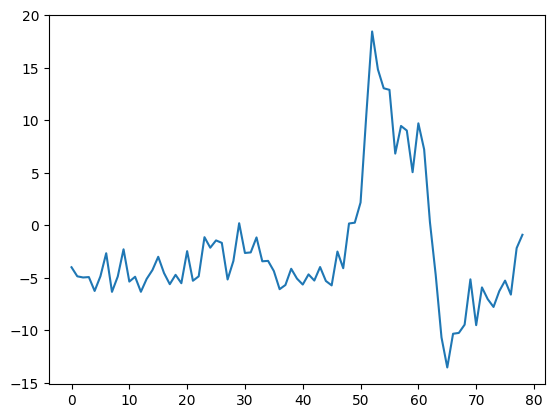

In [41]:
common_factor_df.T[0].plot()

###### Computing the idiosyncratic shocks

In [42]:
idio_shocks_df = eps_idio - common_df.values

# Using simulated data

In [1584]:
# Parameters
T = 10000  # Number of time points
N = 5000  # Number of variables

# Seed for reproducibility
np.random.seed(0)

# Create a random time-series dataframe of size 1xT
time_series_data = pd.DataFrame(np.random.normal(0, 1, size=(1, T)), columns=[f'Time_{i}' for i in range(T)])

# Create a random dataframe of size Nx1
single_variable_data = pd.DataFrame(np.random.normal(0, 1, size=(N, 1)), columns=['Variable'])

# Create a random dataframe of size NxT
panel_data = pd.DataFrame(np.random.normal(0, 0.5, size=(N, T)), columns=[f'Time_{i}' for i in range(T)])



In [1585]:
common_factors_sim = pd.DataFrame(np.dot(single_variable_data,time_series_data))

In [1586]:
sim_data = common_factors_sim.values + panel_data

##### Computing $F$

In [1587]:
sim_data_array = sim_data.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(sim_data_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [1588]:
common_factor_df = top_r_eigenvectors_df.T.dot(sim_data_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

##### Normalizing the common factor F

In [1589]:

common_factor_df_scaled = common_factor_df / np.sqrt(common_factor_df.dot(common_factor_df.T)/len(common_factor_df.T)).values


###### Computing $\Lambda$ via a regression

In [1590]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in sim_data.T.columns:
    y = sim_data.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope  R_squared
0        0   0.005154  0.199058   0.138370
1        1  -0.005995  0.827787   0.729915
2        2   0.004779 -1.714985   0.922048
3        3  -0.004393 -0.182885   0.117458
4        4  -0.004161  0.174669   0.111499
...    ...        ...       ...        ...
4995  4995   0.000359 -0.626670   0.611024
4996  4996  -0.004383 -1.814737   0.928826
4997  4997  -0.004853 -0.731278   0.678143
4998  4998   0.003652  0.573535   0.564653
4999  4999  -0.001166  0.195858   0.132121

[5000 rows x 4 columns]


In [1591]:
Lambda_df = results_df['Slope']

###### Computing $\Lambda\cdot F^T$

In [1592]:
common_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_scaled))

In [1593]:
common_df.columns = sim_data.columns

In [1594]:
common_loadings_sim =  pd.DataFrame(single_variable_data.values.reshape(-1,1) @ time_series_data.values.reshape(1,-1))

###### Computing the idiosyncratic shocks

In [1595]:
idio_shocks_df = sim_data - common_df.values

### Extra: Computing common factor $f_t$ from cross-sectional average

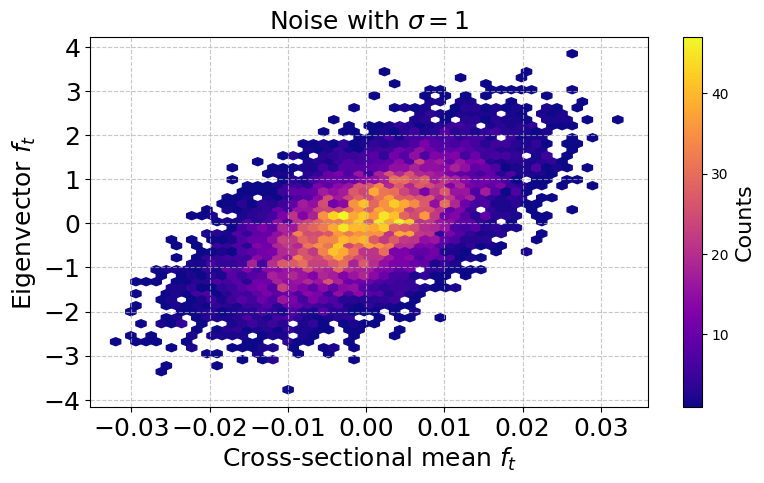

In [1610]:

# Create the scatter plot
plt.figure(figsize=(9, 4.8))
all_values_sim = sim_data.mean().values
all_values = -common_factor_df_scaled.values

plt.title('Noise with $\sigma = 1$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Cross-sectional mean $f_t$', fontsize=18)
plt.ylabel('Eigenvector $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

#plt.savefig('plots/common_product_simulated_large_N_large_T_sigma_1_scatter.png',bbox_inches='tight')
plt.show()

In [1611]:
np.corrcoef(-common_factor_df_scaled.values,sim_data.mean().values)

array([[1.        , 0.60396911],
       [0.60396911, 1.        ]])

## Computing common factor from half the covariance matrix


##### Computing $F$

In [848]:
sim_data_array_half = pd.DataFrame(sim_data_array).T[0:np.int32(T/2)].T.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(sim_data_array_half)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [849]:
common_factor_df_half = top_r_eigenvectors_df.T.dot(sim_data_array_half)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [764]:
common_factor_df_half_scaled = common_factor_df_half / np.sqrt(common_factor_df_half.dot(common_factor_df_half.T)/len(common_factor_df_half.T)).values


###### Computing $\Lambda\cdot F^T$

In [767]:
common_df_half = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_half_scaled))

In [768]:
common_df_half.columns = pd.DataFrame(sim_data_array).T[0:np.int32(T/2)].T.columns

In [769]:
common_loadings_sim =  pd.DataFrame(single_variable_data.values.reshape(-1,1) @ time_series_data.values.reshape(1,-1))

## Computing common factor from a quarter of the covariance matrix

##### Computing $F$

In [773]:
sim_data_array_quarter = pd.DataFrame(sim_data_array).T[0:np.int32(T/4)].T.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(sim_data_array_quarter)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [774]:
common_factor_df_quarter = top_r_eigenvectors_df.T.dot(sim_data_array_quarter)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [775]:
common_factor_df_quarter_scaled = common_factor_df_quarter / np.sqrt(common_factor_df_quarter.dot(common_factor_df_quarter.T)/len(common_factor_df_quarter.T)).values


###### Computing $\Lambda$ via a regression

In [776]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in  pd.DataFrame(sim_data_array).T[0:np.int32(T/4)].columns:
    y = pd.DataFrame(sim_data_array).T[0:np.int32(T/4)][col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_quarter_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_quarter_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope     R_squared
0        0   0.207048  0.155161  2.428447e-04
1        1  -0.006145  0.853648  7.180644e-03
2        2  -0.147006 -1.723734  2.902521e-02
3        3  -0.125171  0.004608  2.088206e-07
4        4   0.056064  0.233936  5.360875e-04
...    ...        ...       ...           ...
4995  4995  -0.101044 -0.668831  4.411046e-03
4996  4996  -0.203382 -1.671585  2.775059e-02
4997  4997  -0.552522 -0.546393  2.939096e-03
4998  4998   0.271712  0.832054  6.822002e-03
4999  4999   0.046532  0.601876  3.541303e-03

[5000 rows x 4 columns]


In [777]:
Lambda_df = results_df['Slope']

###### Computing $\Lambda\cdot F^T$

In [778]:
common_df_quarter = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_quarter_scaled))

In [779]:
common_df_quarter.columns = pd.DataFrame(sim_data_array).T[0:np.int32(T/4)].T.columns

In [780]:
common_loadings_sim =  pd.DataFrame(single_variable_data.values.reshape(-1,1) @ time_series_data.values.reshape(1,-1))

###### Computing the idiosyncratic shocks

In [781]:
#idio_shocks_df_quarter = pd.DataFrame(sim_data_array).T[0:50].T - common_df_quarter.values

### Comparing common factor computed from entire dataframe to common factor computed from half the dataframe

In [782]:
error_common_df = common_df_half.values - common_df.T[0:np.int32(T/2)].T

In [783]:
error_common_quarter_df = common_df_quarter.values - common_df.T[0:np.int32(T/4)].T

In [784]:
error_common_factor_df = (common_factor_df_half.values - common_factor_df.T[0:np.int32(T/2)].T)/10






In [785]:
max_row = error_common_factor_df.idxmax().max()
max_col = error_common_factor_df.max().idxmax()

In [789]:
error_common_factor_quarter_df = (common_factor_df_quarter.values - common_factor_df.T[0:np.int32(T/4)].T)/10


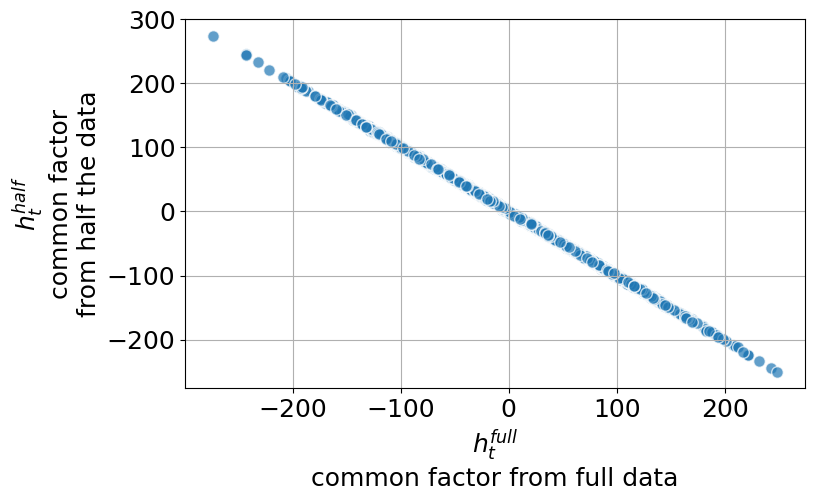

In [790]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df.T[0:np.int32(T/2)].T.values.flatten(), common_factor_df_half.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$h^{full}_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{half}_t$\ncommon factor\nfrom half the data',fontsize = 18)

plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig('plots/common_factor_half.png',bbox_inches='tight')
plt.show()

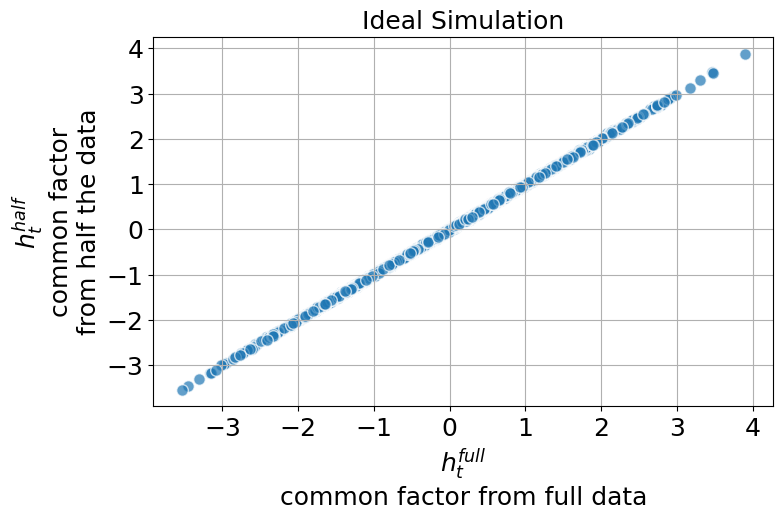

In [791]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(-common_factor_df_scaled.T[0:np.int32(T/2)].T.values.flatten(), common_factor_df_half_scaled.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$h^{full}_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{half}_t$\ncommon factor\nfrom half the data',fontsize = 18)
plt.title('Ideal Simulation', fontsize = 18)
plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots/common_factor_half_scaled_ideal.png',bbox_inches='tight')
plt.show()

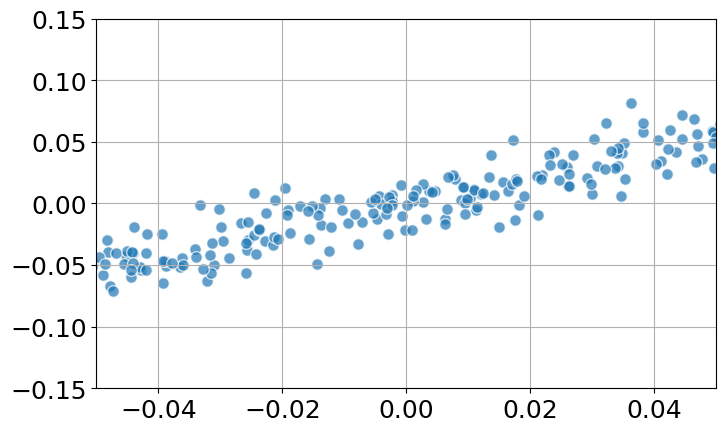

In [582]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(-common_factor_df_scaled.T[0:np.int32(T/2)].T.values.flatten(), common_factor_df_half_scaled.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
#plt.xlabel('$f_t$\ncommon factor from full data',fontsize = 18)
#plt.ylabel('$h^{1/2}_t$\ncommon factor\nfrom half the data',fontsize = 18)

plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-0.05,0.05)  # Adjust the range as needed
plt.ylim(-0.15, 0.15)  # Adjust the range as needed

#plt.savefig('plots/common_factor_half_zoom.png',bbox_inches='tight')
plt.show()

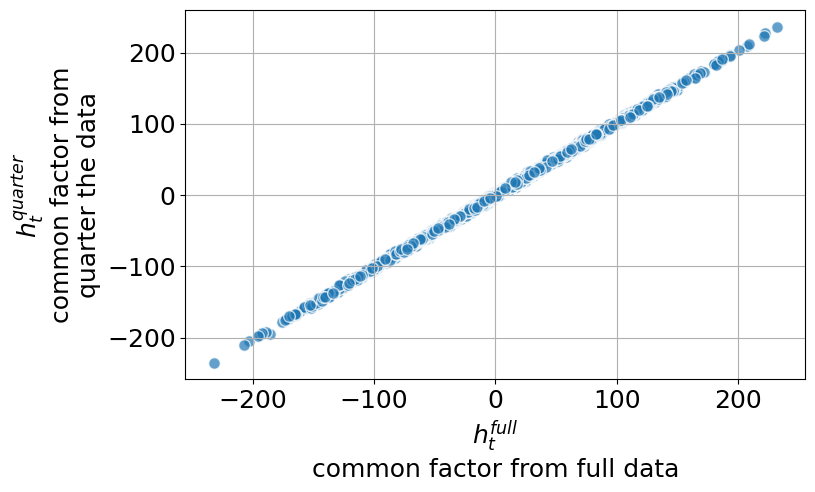

In [792]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df.T[0:np.int32(T/4)].T.values.flatten(), common_factor_df_quarter.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$h^{full}_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{quarter}_t$\ncommon factor from\nquarter the data',fontsize = 18)

plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig('plots/common_factor_quarter.png',bbox_inches='tight')
plt.show()

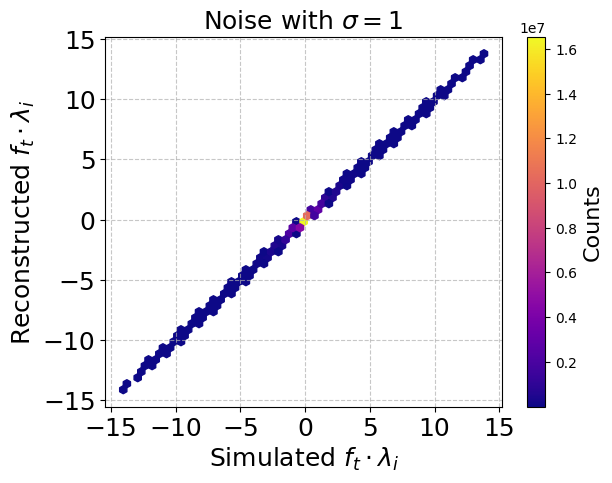

In [831]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 1$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_large_N_large_T_sigma_1_scatter.png',bbox_inches='tight')
plt.show()

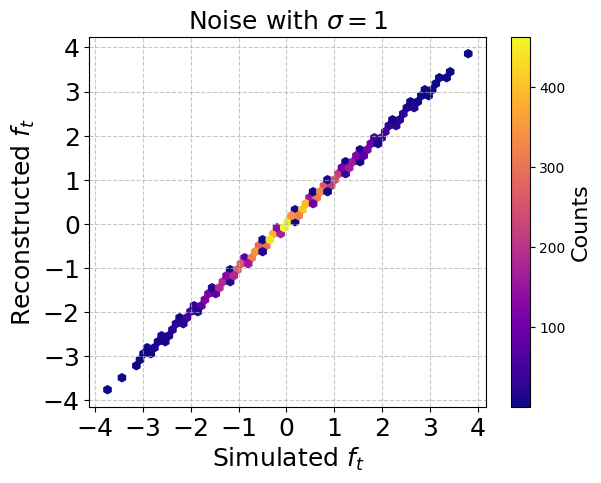

In [834]:
all_values = -common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 1$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_large_N_large_T_sigma_1_scatter.png',bbox_inches='tight')
plt.show()

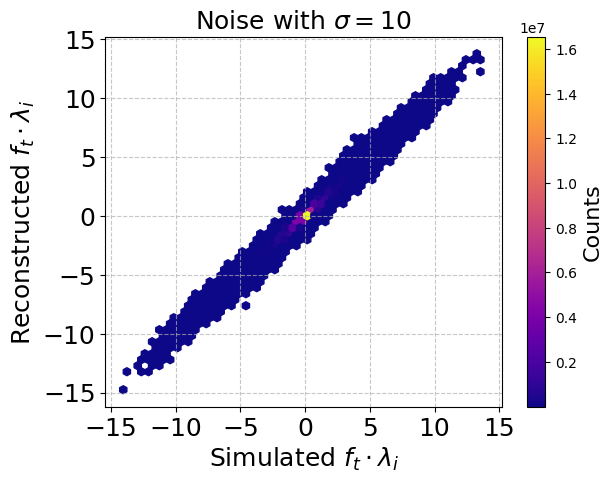

In [850]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 10$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_large_N_large_T_sigma_10_scatter.png',bbox_inches='tight')
plt.show()

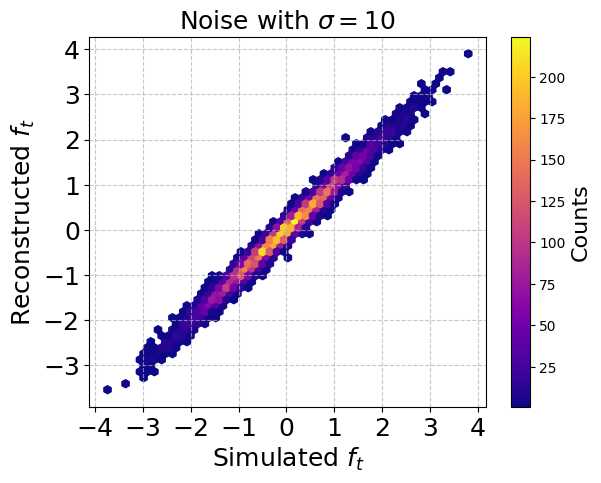

In [851]:
all_values = -common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 10$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_large_N_large_T_sigma_10_scatter.png',bbox_inches='tight')
plt.show()

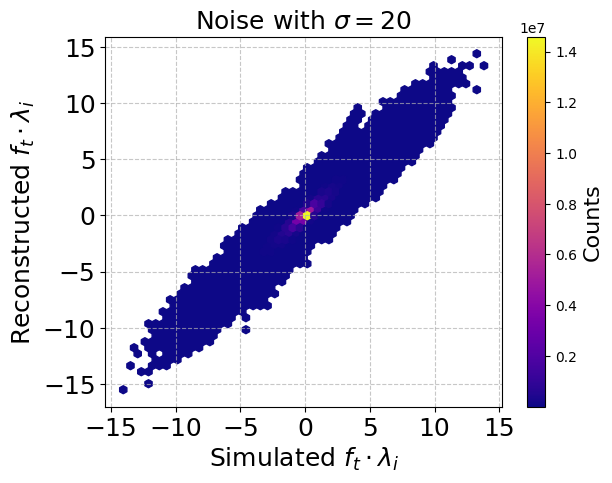

In [865]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 20$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_large_N_large_T_sigma_20_scatter.png',bbox_inches='tight')
plt.show()

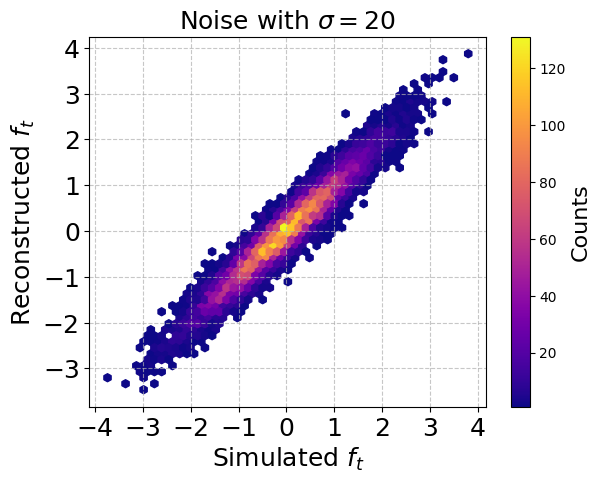

In [866]:
all_values = -common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 20$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_large_N_large_T_sigma_20_scatter.png',bbox_inches='tight')
plt.show()

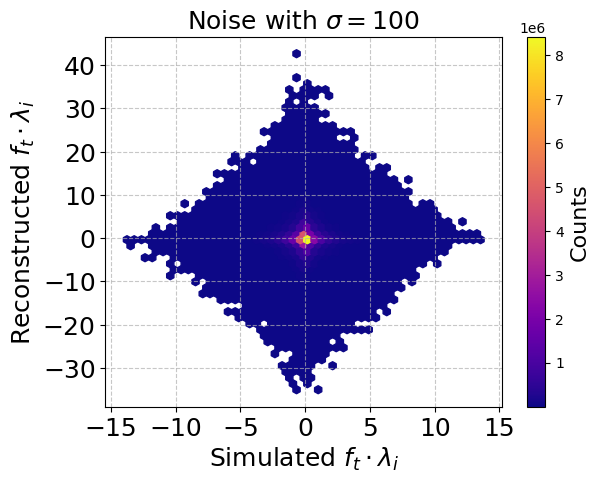

In [880]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 100$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_large_N_large_T_sigma_100_scatter.png',bbox_inches='tight')
plt.show()

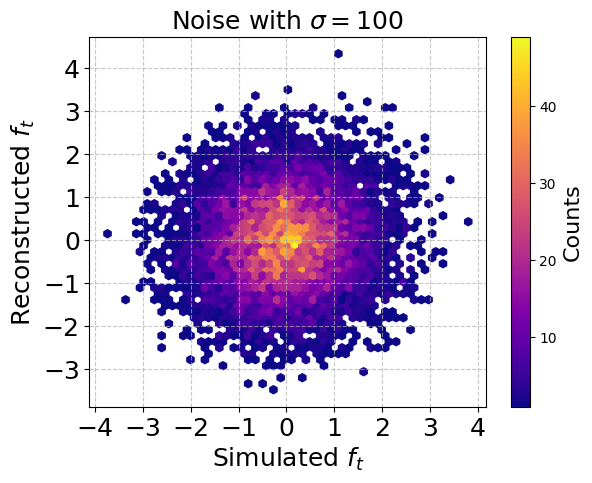

In [881]:
all_values = -common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 100$',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_large_N_large_T_sigma_100_scatter.png',bbox_inches='tight')
plt.show()

# Experiments on real data

## Computing alternative factor loadings via regression - Full data sample

This is the version that we have used for the simulated data as well.

 We can do this exercise for both 
 
- g_log_SIC5
- eps_idio

Hereby, g_log_SIC5 are the observed growth rates while eps_idio are the 'real' growth rates.

##### Computing $F$

In [43]:
eps_idio_array = eps_idio.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(eps_idio_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [44]:
common_factor_eps_df = top_r_eigenvectors_df.T.dot(eps_idio_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [45]:
common_factor_eps_df_scaled = common_factor_eps_df / np.sqrt(common_factor_eps_df.dot(common_factor_eps_df.T)/len(common_factor_eps_df.T)).values


In [64]:
common_factor_eps_df_scaled.columns = eps_idio.columns

###### Computing $\Lambda$ via a regression

In [46]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in eps_idio.T.columns:
    y = eps_idio.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_eps_df_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_eps_df_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope  R_squared
0    01110   0.161396  0.046378   0.045504
1    01130   0.107892  0.061715   0.054789
2    01190   0.073567 -0.052786   0.050490
3    01250  -0.010885 -0.025447   0.006663
4    01290   0.095163 -0.030681   0.003919
..     ...        ...       ...        ...
599  96090  -0.079624  0.801620   0.868925
600  97000  -0.186392 -0.178129   0.320842
601  98000  -0.182240 -0.285134   0.218962
602  98200   0.253922  0.250448   0.134647
603  99000   0.103870 -0.069554   0.005320

[604 rows x 4 columns]


In [47]:
Lambda_df = pd.DataFrame(np.dot(eps_idio_array, common_factor_eps_df_scaled.T)/len(eps_idio_array.T))

###### Computing $\Lambda\cdot F^T$

In [48]:
common_eps_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_eps_df_scaled))

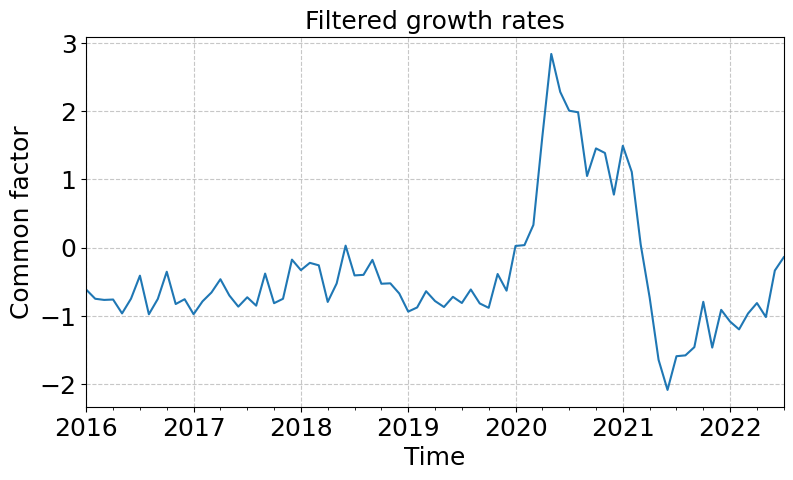

In [78]:
plt.figure(figsize=(9, 4.8))

plt.title('Filtered growth rates',fontsize = 18)
# Create a hexbin plot
common_factor_eps_df_scaled.T[0].plot()


plt.xlabel('Time', fontsize=18)
plt.ylabel('Common factor', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_idiosync.png',bbox_inches='tight')
plt.show()

In [50]:
common_eps_df.columns = eps_idio.columns

###### Computing the idiosyncratic shocks

In [51]:
idio_shocks_df = eps_idio - common_eps_df.values

### Extra: Computing common factor $f_t$ from cross-sectional average

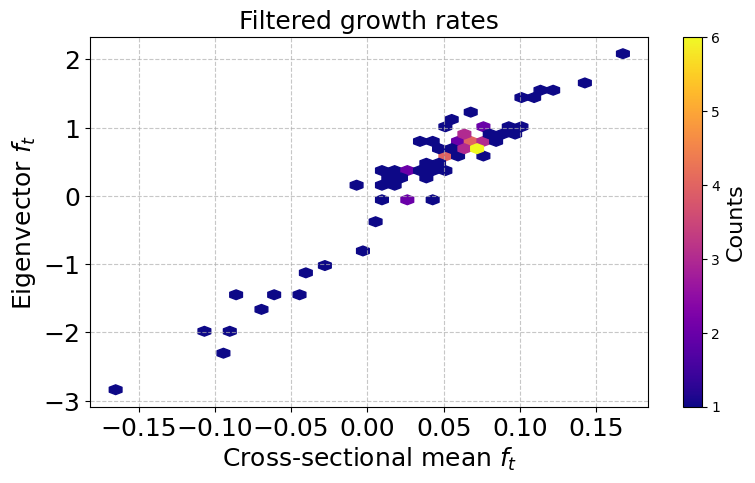

In [1638]:

# Create the scatter plot
plt.figure(figsize=(9, 4.8))
all_values_sim = eps_idio.mean().values
all_values = -common_factor_eps_df_scaled.values

plt.title('Filtered growth rates',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=40, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Cross-sectional mean $f_t$', fontsize=18)
plt.ylabel('Eigenvector $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/comparing_common_factor_techniques.png',bbox_inches='tight')
plt.show()

In [1637]:
np.corrcoef(-common_factor_eps_df_scaled.values,eps_idio.mean().values)

array([[1.        , 0.96552589],
       [0.96552589, 1.        ]])

## Computing alternative factor loadings via regression - Half data sample

This is the version that we have used for the simulated data as well.

 We can do this exercise for both 
 
- g_log_SIC5
- eps_idio

Hereby, g_log_SIC5 are the observed growth rates while eps_idio are the 'real' growth rates.

##### Computing $F$

In [637]:
eps_idio_half_array = eps_idio.T.iloc[0:40].T.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(eps_idio_half_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [638]:
common_factor_half_df = top_r_eigenvectors_df.T.dot(eps_idio_half_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [648]:
common_factor_df_half_scaled = common_factor_half_df / np.sqrt(common_factor_half_df.dot(common_factor_half_df.T)/len(common_factor_half_df.T)).values


###### Computing $\Lambda$ via a regression

In [649]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in eps_idio.T.iloc[0:40].columns:
    y = eps_idio.T.iloc[0:40][col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_half_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_half_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope  R_squared
0    01110   0.102585  0.008688   0.001861
1    01130   0.023672  0.085110   0.133391
2    01190   0.098704  0.000637   0.000020
3    01250  -0.010871  0.108648   0.146042
4    01290   0.069520  0.069544   0.019262
..     ...        ...       ...        ...
599  96090  -0.479011  0.024253   0.003837
600  97000  -0.093908  0.117760   0.192584
601  98000   0.139719  0.050111   0.014218
602  98200  -0.090702 -0.034207   0.002543
603  99000   0.154241  0.029290   0.000956

[604 rows x 4 columns]


In [650]:
Lambda_half_df = pd.DataFrame(np.dot(eps_idio_half_array, common_factor_df_half_scaled.T)/len(eps_idio_half_array.T))

###### Computing $\Lambda\cdot F^T$

In [651]:
common_half_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_half_scaled))

In [652]:
common_half_df.columns = eps_idio.T.iloc[0:40].T.columns

###### Computing the idiosyncratic shocks

In [653]:
idio_shocks_half_df = eps_idio.T.iloc[0:40].T - common_half_df.values

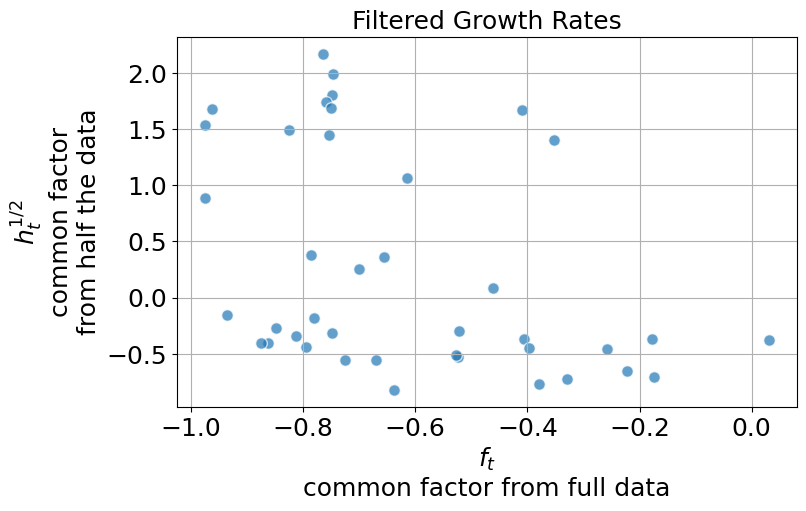

In [662]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df_scaled.T[0:40].T.values.flatten(), common_factor_df_half_scaled.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$f_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{1/2}_t$\ncommon factor\nfrom half the data',fontsize = 18)
plt.title('Filtered Growth Rates', fontsize = 18)
plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(-10, 10)  # Adjust the range as needed
#plt.ylim(-10, 10)  # Adjust the range as needed

plt.savefig('plots/common_factor_filtered_growth_rates_scaled.png',bbox_inches='tight')
plt.show()

## Computing alternative factor loadings via regression - Full data sample - Unfiltered growth rates

This is the version that we have used for the simulated data as well.

 We can do this exercise for both 
 
- g_log_SIC5
- eps_idio

Hereby, g_log_SIC5 are the observed growth rates while eps_idio are the 'real' growth rates.

##### Computing $F$

In [66]:
g_idio_array = g_log_SIC5.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(g_idio_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [67]:
common_factor_df = top_r_eigenvectors_df.T.dot(g_idio_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [69]:
common_factor_df_scaled = common_factor_df / np.sqrt(common_factor_df.dot(common_factor_df.T)/len(common_factor_df.T)).values


In [76]:
common_factor_df_scaled = -common_factor_df_scaled

###### Computing $\Lambda$ via a regression

In [70]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in g_log_SIC5.T.columns:
    y = g_log_SIC5.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope  R_squared
0    01110   0.164693 -0.015164   0.005003
1    01130   0.122342 -0.057147   0.044064
2    01190   0.085516  0.059026   0.067157
3    01250  -0.001396  0.015580   0.002771
4    01290   0.104693  0.015539   0.001123
..     ...        ...       ...        ...
599  96090   0.133601  0.008127   0.005541
600  97000  -0.141308  0.162457   0.277693
601  98000  -0.117301  0.296704   0.240495
602  98200   0.203457 -0.213519   0.109505
603  99000   0.115757  0.089579   0.009910

[604 rows x 4 columns]


In [71]:
Lambda_df = pd.DataFrame(np.dot(eps_idio_array, common_factor_df_scaled.T)/len(eps_idio_array.T))

###### Computing $\Lambda\cdot F^T$

In [1644]:
common_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_scaled))

In [1645]:
common_df.columns = eps_idio.columns

###### Computing the idiosyncratic shocks

In [1646]:
idio_shocks_df = eps_idio - common_df.values

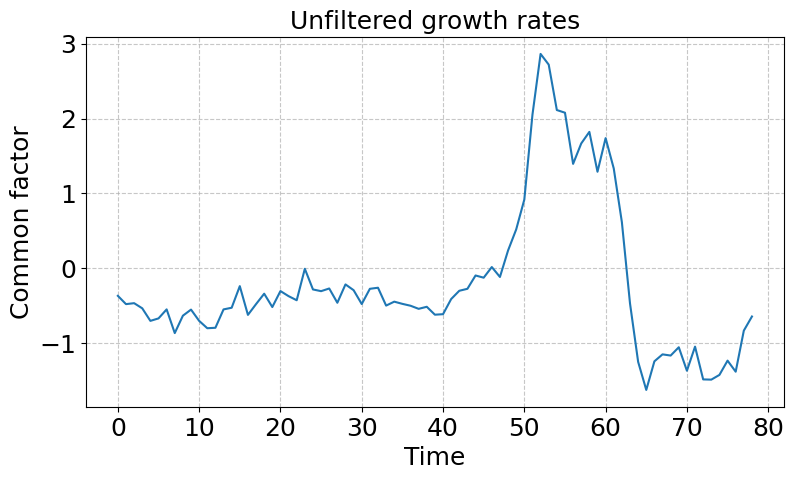

In [77]:
plt.figure(figsize=(9, 4.8))

plt.title('Unfiltered growth rates',fontsize = 18)
# Create a hexbin plot
common_factor_df_scaled.T[0].plot()


plt.xlabel('Time', fontsize=18)
plt.ylabel('Common factor', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_unfilt.png',bbox_inches='tight')
plt.show()

### Extra: Computing common factor $f_t$ from cross-sectional average

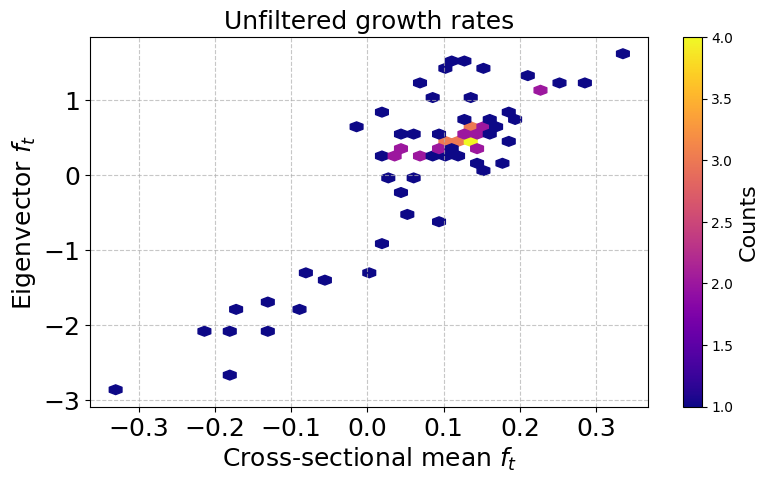

In [1651]:

# Create the scatter plot
plt.figure(figsize=(9, 4.8))
all_values_sim = g_log_SIC5.mean().values
all_values = common_factor_df_scaled.values

plt.title('Unfiltered growth rates',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=40, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Cross-sectional mean $f_t$', fontsize=18)
plt.ylabel('Eigenvector $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/comparing_common_factor_techniques_unfilt.png',bbox_inches='tight')
plt.show()

## Computing alternative factor loadings via regression - Half data sample

This is the version that we have used for the simulated data as well.

 We can do this exercise for both 
 
- g_log_SIC5
- eps_idio

Hereby, g_log_SIC5 are the observed growth rates while eps_idio are the 'real' growth rates.

##### Computing $F$

In [405]:
eps_idio_half_array = g_log_SIC5.T.iloc[0:40].T.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(eps_idio_half_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [406]:
common_factor_half_df = top_r_eigenvectors_df.T.dot(eps_idio_half_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [407]:
common_factor_df_half_scaled = common_factor_half_df / np.sqrt(common_factor_half_df.dot(common_factor_half_df.T)/len(common_factor_half_df.T)).values


###### Computing $\Lambda$ via a regression

In [408]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in g_log_SIC5.T.iloc[0:40].columns:
    y = g_log_SIC5.T.iloc[0:40][col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_half_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_half_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

      Time  Intercept     Slope  R_squared
0    01110   0.114640  0.001214   0.000032
1    01130   0.040159  0.091471   0.136734
2    01190   0.102946 -0.000477   0.000011
3    01250  -0.002334  0.113429   0.161707
4    01290   0.078159  0.052965   0.011459
..     ...        ...       ...        ...
599  96090   0.119615  0.003917   0.001552
600  97000  -0.081194  0.120083   0.203777
601  98000   0.178861  0.029524   0.004173
602  98200  -0.091684 -0.034105   0.002598
603  99000   0.158746  0.042851   0.002121

[604 rows x 4 columns]


In [409]:
Lambda_half_df = pd.DataFrame(np.dot(eps_idio_half_array, common_factor_df_half_scaled.T)/len(eps_idio_half_array.T))

###### Computing $\Lambda\cdot F^T$

In [410]:
common_half_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_half_scaled))

In [411]:

common_half_df.columns = g_log_SIC5.T.iloc[0:40].T.columns

###### Computing the idiosyncratic shocks

In [412]:
idio_shocks_half_df = g_log_SIC5.T.iloc[0:40].T - common_half_df.values

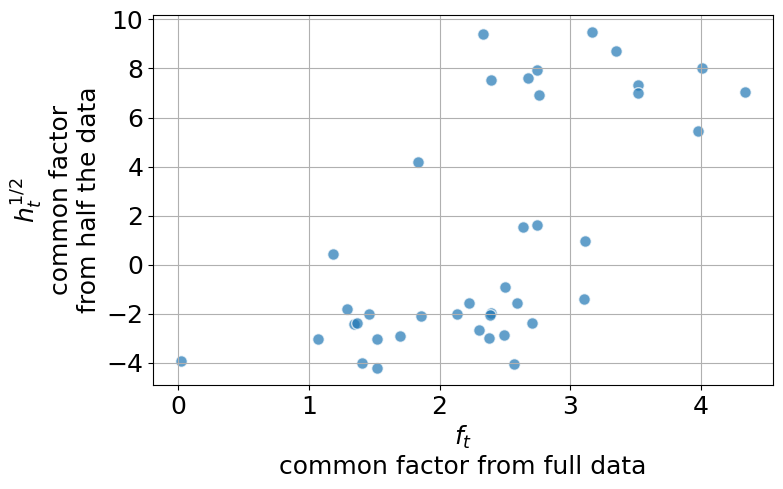

In [414]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df.T[0:40].T.values.flatten(), common_factor_half_df.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$f_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{1/2}_t$\ncommon factor\nfrom half the data',fontsize = 18)

plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(-10, 10)  # Adjust the range as needed
#plt.ylim(-10, 10)  # Adjust the range as needed

plt.savefig('plots/common_factor_unfiltered_growth_rates.png',bbox_inches='tight')
plt.show()

# Simulated Data of same size as real data

# Using simulated data

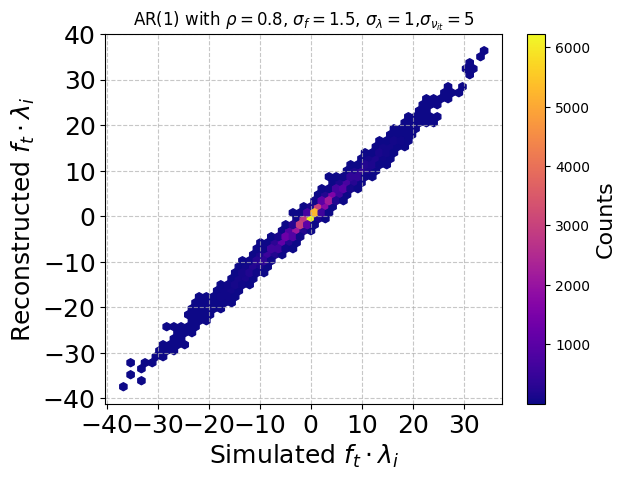

In [1398]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)


plt.title('AR(1) with $\\rho =0.8$, $\\sigma_f = 1.5$, $\\sigma_{\\lambda} = 1$,$\\sigma_{\\nu_{it}} = 5$')
plt.savefig('plots/common_product_simulated_realistic_AR1.png',bbox_inches='tight')
plt.show()

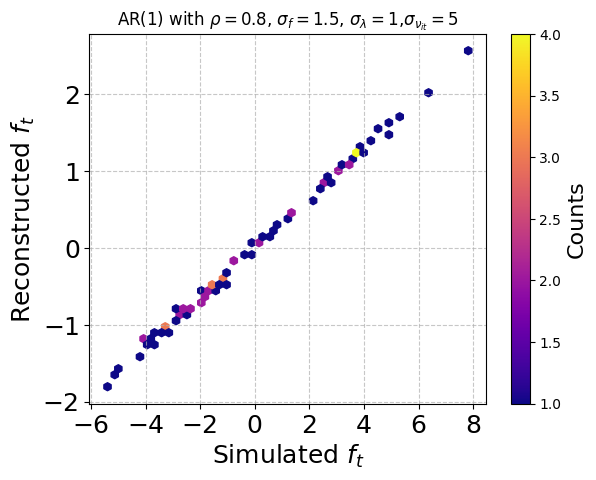

In [1400]:
all_values = -common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)


plt.title('AR(1) with $\\rho =0.8$, $\\sigma_f = 1.5$, $\\sigma_{\\lambda} = 1$,$\\sigma_{\\nu_{it}} = 5$')
plt.savefig('plots/common_factor_simulated_realistic_AR1.png',bbox_inches='tight')
plt.show()

### AR(1) Technique

In [1411]:
# Parameters
T = 80  # Number of time points
N = 600  # Number of variables
rho = 0.8
sigma = 1.5 # Standard deviation of the noise


# Seed for reproducibility
np.random.seed(0)

# Initialize the time series
time_series_data = np.zeros(T)

# Generate the AR(1) process
for t in range(1, T):
    time_series_data[t] = rho * time_series_data[t-1] + np.random.normal(0, sigma)

    
    
# Parameters
rho = 0.8
sigma = 1  # Standard deviation of the noise

# Initialize the time series
single_variable_data = np.zeros(N) 

# Generate the AR(1) process
for t in range(1, N):
    single_variable_data[t] = rho * single_variable_data[t-1] + np.random.normal(0, sigma)
    
single_variable_data = pd.DataFrame(single_variable_data.reshape((N, 1)))
time_series_data = pd.DataFrame(time_series_data.reshape((1, T)))
time_series_data = time_series_data / np.sqrt(time_series_data.dot(time_series_data.T)/len(time_series_data.T)).values



# Create the noise terms
panel_data = pd.DataFrame(np.random.normal(0, 5, size=(N, T)), columns=[f'Time_{i}' for i in range(T)])


In [1410]:
time_series_data_scaled.T.var()

0    1.01156
dtype: float64

In [1355]:
common_factors_sim = pd.DataFrame(np.dot(single_variable_data,time_series_data))

In [1356]:
sim_data = common_factors_sim.values + panel_data

### Normal Distribution Technique

In [1350]:
# Parameters
T = 80  # Number of time points
N = 600  # Number of variables

# Seed for reproducibility
np.random.seed(0)

# Create a random time-series dataframe of size 1xT
time_series_data = pd.DataFrame(np.random.normal(0, 1, size=(1, T)), columns=[f'Time_{i}' for i in range(T)])

# Create a random dataframe of size Nx1
single_variable_data = pd.DataFrame(np.random.normal(0, 1, size=(N, 1)), columns=['Variable'])

# Create a random dataframe of size NxT
panel_data = pd.DataFrame(np.random.normal(0, 100, size=(N, T)), columns=[f'Time_{i}' for i in range(T)])




In [1068]:
common_factors_sim = pd.DataFrame(np.dot(single_variable_data,time_series_data))

In [1069]:
sim_data = common_factors_sim.values + panel_data

##### Computing $F$

In [1357]:
sim_data_array = sim_data.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(sim_data_array)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [1358]:
common_factor_df = top_r_eigenvectors_df.T.dot(sim_data_array)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [1359]:
common_factor_df_scaled = common_factor_df / np.sqrt(common_factor_df.dot(common_factor_df.T)/len(common_factor_df.T)).values


###### Computing $\Lambda$ via a regression

In [1360]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in sim_data.T.columns:
    y = sim_data.T[col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

     Time  Intercept      Slope  R_squared
0       0  -0.123758  -0.301266   0.003000
1       1  -0.087659   0.772443   0.033781
2       2  -0.886464   3.696581   0.359432
3       3   1.364113  -0.167241   0.001438
4       4   0.115348  -1.164407   0.059256
..    ...        ...        ...        ...
595   595  -0.777475  13.899930   0.907897
596   596  -0.615936  10.272567   0.834213
597   597  -0.189903   6.484467   0.617788
598   598   0.415012   8.529509   0.786887
599   599  -0.483557   4.055377   0.409922

[600 rows x 4 columns]


In [1361]:
Lambda_df = results_df['Slope']

###### Computing $\Lambda\cdot F^T$

In [1369]:
common_df = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_scaled))

In [1363]:
common_df.columns = sim_data.columns

In [1364]:
common_loadings_sim =  pd.DataFrame(single_variable_data.values.reshape(-1,1) @ time_series_data.values.reshape(1,-1))

###### Computing the idiosyncratic shocks

In [1365]:
idio_shocks_df = sim_data - common_df.values

In [1366]:
idio_shocks_df.mean()

Time_0     0.207300
Time_1    -0.252796
Time_2     0.339864
Time_3     0.018625
Time_4     0.300481
             ...   
Time_75   -0.227099
Time_76   -0.041514
Time_77   -0.078888
Time_78   -0.172117
Time_79   -0.058518
Length: 80, dtype: float64

## Computing common factor from half the covariance matrix

##### Computing $F$

In [979]:
sim_data_array_half = pd.DataFrame(sim_data_array).T[0:np.int32(T/2)].T.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(sim_data_array_half)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [722]:
common_factor_df_half = top_r_eigenvectors_df.T.dot(sim_data_array_half)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [723]:
common_factor_df_half_scaled = common_factor_df_half / np.sqrt(common_factor_df_half.dot(common_factor_df_half.T)/len(common_factor_df_half.T)).values


###### Computing $\Lambda$ via a regression

In [724]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in  pd.DataFrame(sim_data_array).T[0:np.int32(T/2)].columns:
    y = pd.DataFrame(sim_data_array).T[0:np.int32(T/2)][col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_half_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_half_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

     Time  Intercept     Slope  R_squared
0       0   0.202051 -1.355128   0.014300
1       1  -1.394051  0.267637   0.001109
2       2  -2.451802  0.579692   0.004096
3       3   2.964456 -4.194774   0.147840
4       4   0.339706  4.624886   0.221683
..    ...        ...       ...        ...
595   595  -1.892222  1.792247   0.049097
596   596  -0.893996 -0.597411   0.004028
597   597  -1.110295  3.045620   0.094880
598   598   2.046831  2.879881   0.097595
599   599  -0.334699  1.054378   0.009388

[600 rows x 4 columns]


In [725]:
Lambda_df = results_df['Slope']

###### Computing $\Lambda\cdot F^T$

In [726]:
common_df_half = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_half_scaled))

In [727]:
common_df_half.columns = pd.DataFrame(sim_data_array).T[0:np.int32(T/2)].T.columns

In [728]:
common_loadings_sim =  pd.DataFrame(single_variable_data.values.reshape(-1,1) @ time_series_data.values.reshape(1,-1))

###### Computing the idiosyncratic shocks

In [729]:
idio_shocks_df_half = pd.DataFrame(sim_data_array).T[0:40].T - common_df_half.values

## Computing common factor from a quarter of the covariance matrix

##### Computing $F$

In [730]:
sim_data_array_quarter = pd.DataFrame(sim_data_array).T[0:np.int32(T/4)].T.values

# Compute the matrix product eps_idio * eps_idio^

matrix_product = np.cov(sim_data_array_quarter)

# Compute the eigenvalues and eigenvectors of the matrix product
eigenvalues, eigenvectors = np.linalg.eigh(matrix_product)

# Sort the eigenvalues in descending order and get the indices of the r largest
r = 1  # Number of largest eigenvalues to keep
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues sorted in descending order
top_r_indices = sorted_indices[:r]  # Indices of the r largest eigenvalues

# Collect the corresponding eigenvectors
top_r_eigenvectors = eigenvectors[:, top_r_indices]

# Convert the result to a DataFrame (optional)
#top_r_eigenvectors_df = np.sqrt(len(eps_idio_array.T))*pd.DataFrame(top_r_eigenvectors)
top_r_eigenvectors_df = pd.DataFrame(top_r_eigenvectors)


In [731]:
common_factor_df_quarter = top_r_eigenvectors_df.T.dot(sim_data_array_quarter)
#common_factor_df = common_factor_df/np.sqrt(len(eps_idio_array.T))

In [732]:
common_factor_df_quarter_scaled = common_factor_df_quarter / np.sqrt(common_factor_df_quarter.dot(common_factor_df_quarter.T)/len(common_factor_df_quarter.T)).values


###### Computing $\Lambda$ via a regression

In [733]:

# Prepare a list to store regression results
regression_results = []

# Perform regression for each column in Y against X
for col in  pd.DataFrame(sim_data_array).T[0:np.int32(T/4)].columns:
    y = pd.DataFrame(sim_data_array).T[0:np.int32(T/4)][col].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(common_factor_df_quarter_scaled.values.reshape(-1, 1), y)
    regression_results.append({
        'Time': col,
        'Intercept': model.intercept_[0],
        'Slope': model.coef_[0][0],
        'R_squared': model.score(common_factor_df_quarter_scaled.values.reshape(-1, 1), y)
    })

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(regression_results)
print(results_df)

     Time  Intercept     Slope  R_squared
0       0  -0.778068 -3.480317   0.073405
1       1  -1.365042 -0.408843   0.002542
2       2  -2.956871  2.624542   0.068661
3       3   1.231852  4.391703   0.155339
4       4   0.686620 -2.777652   0.088012
..    ...        ...       ...        ...
595   595  -2.182289  2.928248   0.136212
596   596  -2.042230 -0.153225   0.000410
597   597   2.996982 -1.689618   0.047041
598   598   0.573972 -4.662775   0.240150
599   599  -2.516063  0.457293   0.001687

[600 rows x 4 columns]


In [734]:
Lambda_df = results_df['Slope']

###### Computing $\Lambda\cdot F^T$

In [735]:
common_df_quarter = pd.DataFrame(results_df['Slope'].values.reshape(-1, 1).dot(common_factor_df_quarter_scaled))

In [736]:
common_df_quarter.columns = pd.DataFrame(sim_data_array).T[0:np.int32(T/4)].T.columns

In [737]:
common_loadings_sim =  pd.DataFrame(single_variable_data.values.reshape(-1,1) @ time_series_data.values.reshape(1,-1))

###### Computing the idiosyncratic shocks

In [738]:
idio_shocks_df_quarter = pd.DataFrame(sim_data_array).T[0:20].T - common_df_quarter.values

### Comparing common factor computed from entire dataframe to common factor computed from half the dataframe

In [739]:
error_common_df = common_df_half.values - common_df.T[0:np.int32(T/2)].T

In [740]:
error_common_quarter_df = common_df_quarter.values - common_df.T[0:np.int32(T/4)].T

In [741]:
error_common_factor_df = (common_factor_df_half.values - common_factor_df.T[0:np.int32(T/2)].T)/10






In [742]:
max_row = error_common_factor_df.idxmax().max()
max_col = error_common_factor_df.max().idxmax()

In [746]:
error_common_factor_quarter_df = (common_factor_df_quarter.values - common_factor_df.T[0:np.int32(T/4)].T)/10


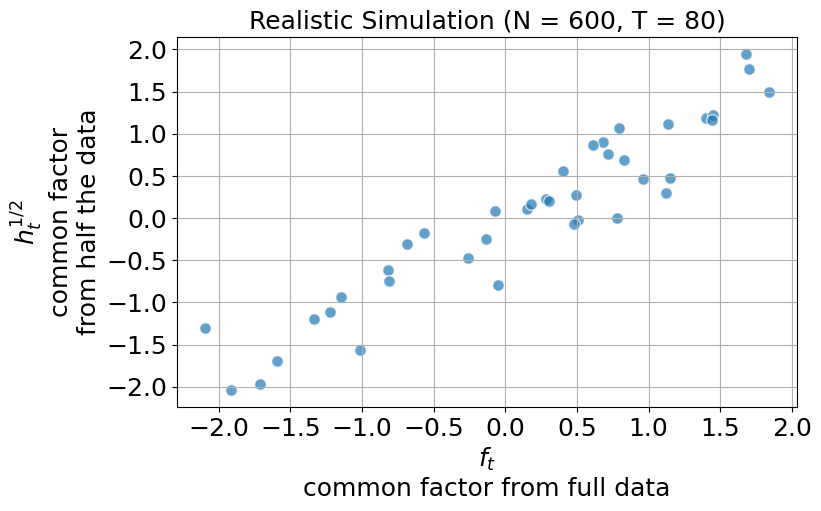

In [748]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df_scaled.T[0:np.int32(T/2)].T.values.flatten(), common_factor_df_half_scaled.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$f_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{1/2}_t$\ncommon factor\nfrom half the data',fontsize = 18)
plt.title('Realistic Simulation (N = 600, T = 80)', fontsize = 18)
plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots/common_factor_half_size_as_real.png',bbox_inches='tight')
plt.show()

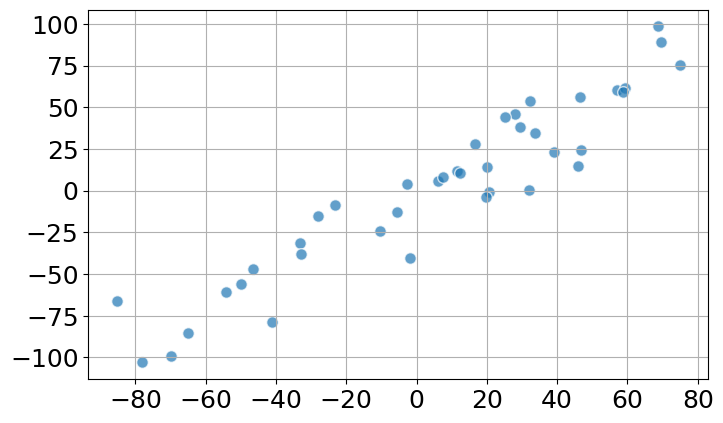

In [503]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df.T[0:np.int32(T/2)].T.values.flatten(), common_factor_df_half.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
#plt.xlabel('$f_t$\ncommon factor from full data',fontsize = 18)
#plt.ylabel('$h^{1/2}_t$\ncommon factor\nfrom half the data',fontsize = 18)

plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(-10, 10)  # Adjust the range as needed
#plt.ylim(-10, 10)  # Adjust the range as needed

plt.savefig('plots/common_factor_half_size_as_real_zoom.png',bbox_inches='tight')
plt.show()

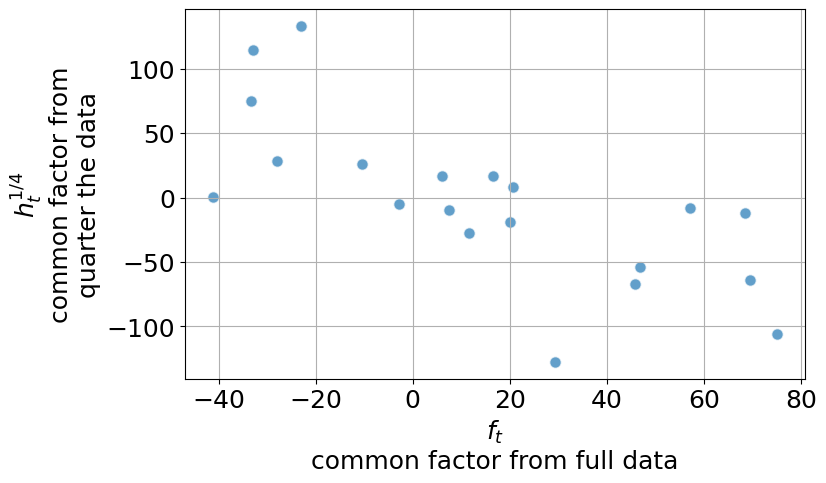

In [504]:


# Create the scatter plot
plt.figure(figsize=(8, 4.8))
plt.scatter(common_factor_df.T[0:np.int32(T/4)].T.values.flatten(), common_factor_df_quarter.values.flatten(), alpha=0.7, edgecolors='w', s=70)

# Add title and labels
plt.xlabel('$f_t$\ncommon factor from full data',fontsize = 18)
plt.ylabel('$h^{1/4}_t$\ncommon factor from\nquarter the data',fontsize = 18)

plt.grid(True)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots/common_factor_quarter_size_as_real.png',bbox_inches='tight')
plt.show()

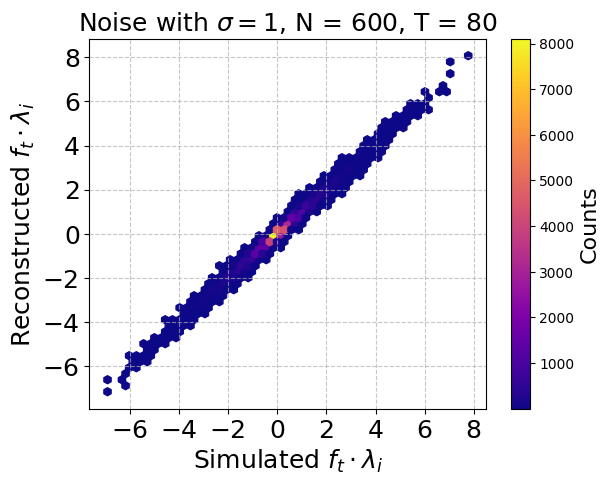

In [946]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 1$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_realistic_sigma_1_scatter.png',bbox_inches='tight')
plt.show()

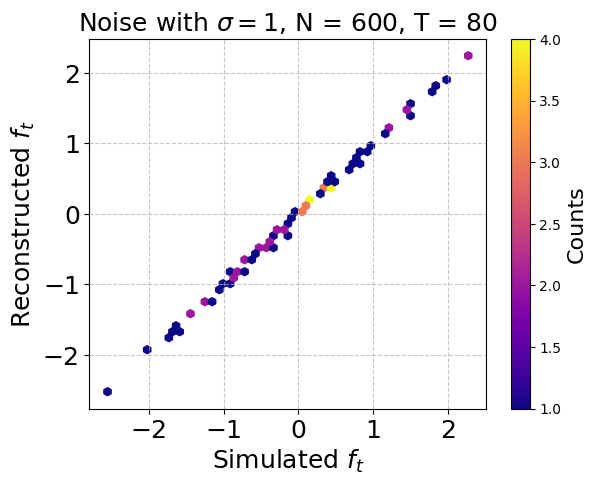

In [947]:
all_values = -common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 1$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_realistic_sigma_1_scatter.png',bbox_inches='tight')
plt.show()

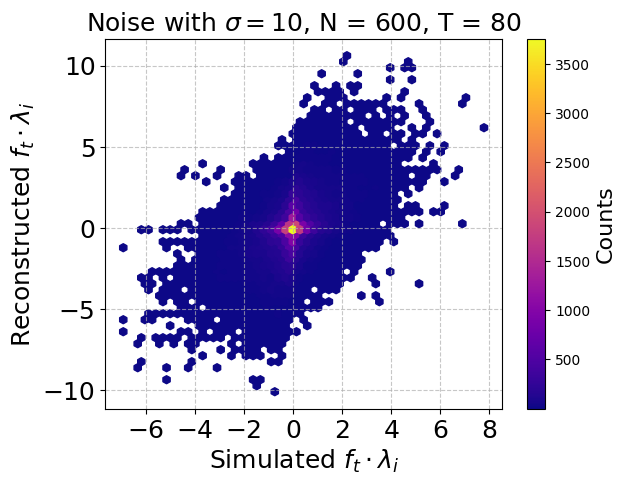

In [930]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 10$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_realistic_sigma_10_scatter.png',bbox_inches='tight')
plt.show()

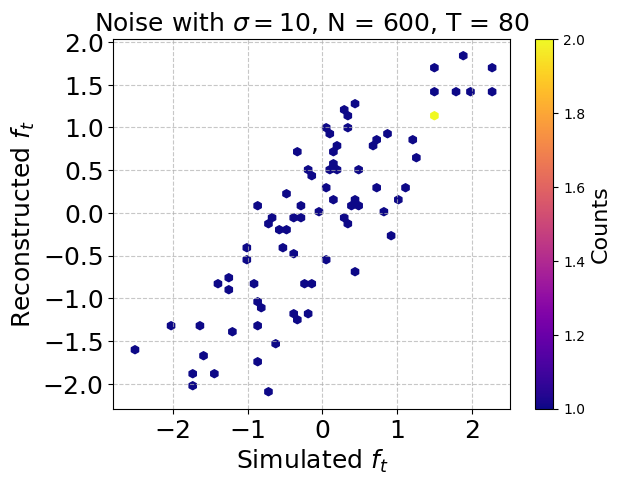

In [932]:
all_values = common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 10$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_realistic_sigma_10_scatter.png',bbox_inches='tight')
plt.show()

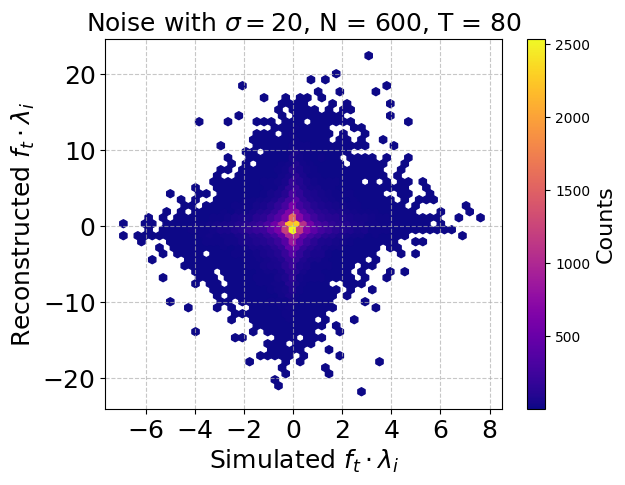

In [965]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 20$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_realistic_sigma_20_scatter.png',bbox_inches='tight')
plt.show()

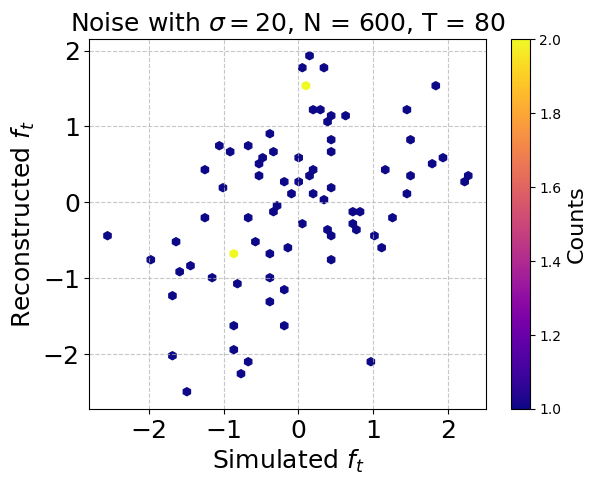

In [963]:
all_values = common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 20$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_realistic_sigma_20_scatter.png',bbox_inches='tight')
plt.show()

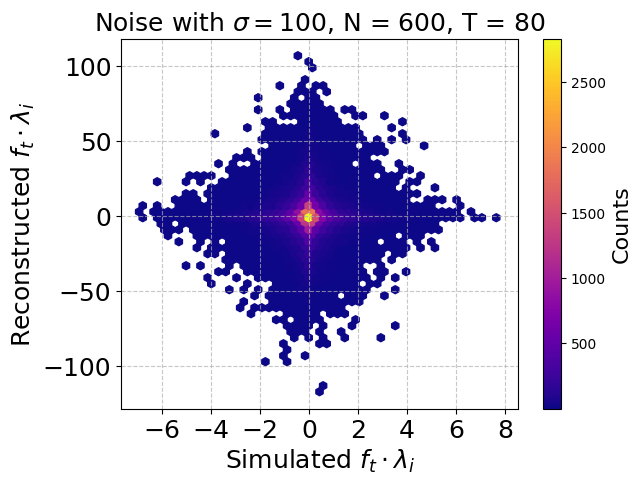

In [980]:
all_values = common_df.values.flatten()

all_values_sim = common_factors_sim.values.flatten()

plt.title('Noise with $\sigma = 100$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t\cdot \lambda_i$', fontsize=18)
plt.ylabel('Reconstructed $f_t\cdot \lambda_i$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_product_simulated_realistic_sigma_100_scatter.png',bbox_inches='tight')
plt.show()

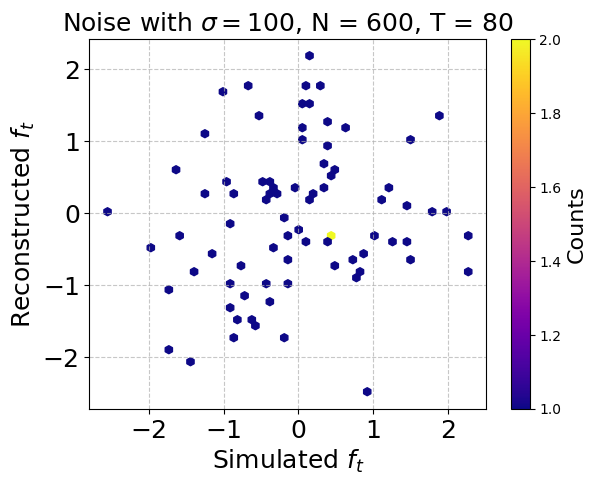

In [982]:
all_values = common_factor_df_scaled.values.flatten()

all_values_sim = time_series_data.values.flatten()

plt.title('Noise with $\sigma = 100$, N = 600, T = 80',fontsize = 18)
# Create a hexbin plot
plt.hexbin(all_values_sim, all_values, gridsize=50, cmap = 'plasma',mincnt=1)

# Add a color bar
cb = plt.colorbar()
cb.set_label('Counts', fontsize = 16)

plt.xlabel('Simulated $f_t$', fontsize=18)
plt.ylabel('Reconstructed $f_t$', fontsize=18)

# Increase the size of x and y axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('plots/common_factor_simulated_realistic_sigma_100_scatter.png',bbox_inches='tight')
plt.show()